# Calulate SEC transport in INALT20 and observation along 23$^{\circ}$W

For both, model and observations we calculate the central position $ Y_{CM} $ and along-pathway intensity $ INT $ of zonal currents using the algorithm of Hsin (2012). 

\begin{equation}
Y_{CM}(x,t) = \frac{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} y\ u(x,y,z,t)\ dy\ dz}{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} u(x,y,z,t)\ dy\ dz}
\label{equ_Y_CM}
\end{equation}

\begin{equation}
INT(x,t) = \int_{Z_l}^{Z_u} \int_{Y_{CM}-W}^{Y_{CM}+W} u(x,y,z,t)\ dy\ dz 
\label{equ_INT}
\end{equation}


where $y$ is latitude, $x$ is longitude, $u$ is zonal velocity, $z$ is depth, $t$ is time, $Z_u$ ($Z_l$) is upper (lower) boundary of the flow, $Y_N$ ($Y_S$) is northern (southern) limit of the flow, and $W$ is the half mean width of the flow.

![](../figures/INALT20_obs_23w_comparison/1_INALT20_obs_23w_1999_2012.png)

For transport calculation of the SEC we use the following boundary conditions:

Two transports: 
* $Z_u = 0\,$kg$\,$m$^{-3}$ to $Z_l = 24.5\,$kg$\,$m$^{-3}$
* $Z_u = 24.5\,$kg$\,$m$^{-3}$ to $Z_l = 26.8\,$kg$\,$m$^{-3}$ 

tropical surface waters (potential density anomaly σt lower than 26.3), upper central waters (26.3<σt<26.8) (Elmoussaoui et al., 2005; Rhein and Stramma, 2005; Kirchner et al., 2009; Peña-Izquierdo et al., 2015)." (Kounta et al, 2018, Goes et al, 2013; Kirchner 2009 (ref in Goes)) 

$Y_N = 5^{\circ}$N, 

$Y_S = 0^{\circ}$S

Based on monthly mean climatology (INATL20_SEC_boundaries) we choose $W = 2^{\circ}$.

The depth of the SEC core $Z_{CM}$ will be estimated similar to $Y_{CM}$:

\begin{equation}
Z_{CM}(x,t) = \frac{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} z\ u(x,y,z,t)\ dy\ dz}{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} u(x,y,z,t)\ dy\ dz}
\label{equ_Z_CM}
\end{equation}

## Tech preample

In [1]:
%matplotlib inline
import os
import dask
import cmocean
import datetime
# import nc_time_axis
import cftime
import gsw
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
# import xorca_box as xbox
from pathlib import Path
from scipy.io import loadmat
# from xorca.lib import load_xorca_dataset
# from xorca_lonlat2ij import get_ij
from datetime import datetime

## Dask jobqueue and client
To controle the resources used for parallel computations on computing nodes.

In [2]:
import dask_jobqueue
cluster = dask_jobqueue.SLURMCluster(
    # Dask worker size
    cores=4, memory='24GB',
    processes=1, # Dask workers per job
    # SLURM job script things
    queue='cluster', walltime='01:00:00',
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',
    log_directory='./slurm_logs'
)

/gxfs_home/geomar/smomw294/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33325 instead
  http_address["port"], self.http_server.port


In [3]:
from dask.distributed import Client

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://172.18.4.12:40177 Dashboard: http://172.18.4.12:33325/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
cluster.adapt(
    minimum=1, maximum=20,
)

## Output parameters

In [6]:
out_dir_fig = Path('../figures/INALT20_SEC_boundaries/')
Path(out_dir_fig).mkdir(parents=True, exist_ok=True)
out_fig_1 = 'INALT_JRA_CORE_SEC_zonal'
out_fig_2 = 'INALT_JRA_SEC_zonal'
out_fig_3 = 'INALT_CORE_SEC_zonal'
out_fig_4 = 'INALT_JRA_CORE_SEC_merid'
out_fig_5 = 'INALT_JRA_SEC_merid'
out_fig_6 = 'INALT_CORE_SEC_merid'
fig_format = '.png'

savefig = 1; #set one if figures should be saved

## Input parameters
For INALT20 

In [7]:
run_calc_1M = 0 #set 1 if annual mean should be recalculated
global_data_path = Path("/sfs/fs1/work-geomar1/smomw044/")
JRA_path = "INALT20.L46-KFS10X"
exp_id = "INALT20.L46-KFS10?"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

in_dir_data_EUC = Path('../data/INALT20_EUC_boundaries/')
in_dir_data_NECC = Path('../data/INALT20_NEUC_NECC_boundaries/')

# chunk sizes
chu_x = 100 # None means take the full dataset
chu_y = 100
chu_z = 9
chu_t = 1

# variables wanted
vars_want = ['vosaline','votemper','vozocrtx']

Calculation of EUC - Boundary conditions

In [8]:
lonlim = [-45, -17]
latlim = [-2.5, 10]
zlim = [0, 400]

## NECC integers
xclim1_NECC = 489
xclim2_NECC = 1050
yclim1_NECC = 1680
yclim2_NECC = 1831

## EUC integers
xclim1_EUC = 590
xclim2_EUC = 1389 
yclim1_EUC = 1579
yclim2_EUC = 1679 

# for nc-file attrs
lat_s = latlim[0]
lat_n = latlim[1]
lon_e = lonlim[0]
lon_w = lonlim[1]

p_ref = 0 # dbar; reference pressure for potential density calculation

Find relevant data files for INALT20

## Load monthly mean data

In [9]:
aux_files = list(sorted(
        (global_data_path/ JRA_path).glob(f"{nest_prefix}[m,n]*.nc")
    ))

aux_files

with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            aux_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                    "y":chu_y,"x":chu_x})

ds_mesh_EUC = ds_mesh.sel(z=slice(0,18),
               x=slice(xclim1_EUC,xclim2_EUC),
               y=slice(yclim1_EUC,yclim2_EUC))


ds_mesh_NECC = ds_mesh.sel(z=slice(0,18),
               x=slice(xclim1_NECC,xclim2_NECC),
               y=slice(yclim1_NECC,yclim2_NECC))

In [10]:
CORE_files_EUC = list(sorted(
    (in_dir_data_EUC.glob(
        f"{nest_prefix}{CORE_exp_id}{'_CORE_1M*.nc'}"
    ))))

JRA_files_EUC = list(sorted(
    (in_dir_data_EUC.glob(
        f"{nest_prefix}{exp_id[0:-1]}{'X_JRA_1M*.nc'}"
    ))))

CORE_files_NECC = list(sorted(
    (in_dir_data_NECC.glob(
        f"{nest_prefix}{CORE_exp_id}{'_CORE_1M*.nc'}"
    ))))

JRA_files_NECC = list(sorted(
    (in_dir_data_NECC.glob(
        f"{nest_prefix}{exp_id[0:-1]}{'X_JRA_1M*.nc'}"
    ))))

CORE_files = CORE_files_EUC+CORE_files_NECC
JRA_files = JRA_files_EUC+JRA_files_NECC

print(f"Found {len(CORE_files)} CORE NECC files and {len(JRA_files)} JRA NECC files.")

Found 104 CORE NECC files and 122 JRA NECC files.


In [11]:
with dask.config.set(scheduler='synchronous'):
    ds_CORE_EUC = xr.open_mfdataset(
        CORE_files_EUC,
        concat_dim='time',
        decode_cf=True,
        chunks={"depth":chu_z, 
                 "y":chu_y, 
                 "x_c":chu_x,
                 "x_r":chu_x})
    
    ds_CORE_NECC = xr.open_mfdataset(
        CORE_files_NECC,
        concat_dim='time',
        decode_cf=True,
        chunks={"depth":chu_z, 
                 "y":chu_y, 
                 "x_c":chu_x,
                 "x_r":chu_x})


In [12]:
with dask.config.set(scheduler='synchronous'):
    ds_JRA_EUC = xr.open_mfdataset(
        JRA_files_EUC,
        concat_dim=['time'],
        decode_cf=True,
        chunks={"depth":chu_z, 
                 "y":chu_y, 
                 "x_c":chu_x,
                 "x_r":chu_x})
    
    ds_JRA_NECC = xr.open_mfdataset(
        JRA_files_NECC,
        concat_dim=['time'],
        decode_cf=True,
        chunks={"depth":chu_z, 
                 "y":chu_y, 
                 "x_c":chu_x,
                 "x_r":chu_x})

In [13]:
ds_JRA_EUC = ds_JRA_EUC.assign_coords(glamu=(['y','x'],ds_mesh_EUC.glamu.squeeze()))
lon = ds_JRA_EUC.glamu.isel(y=5)
ds_JRA_EUC = ds_JRA_EUC.assign_coords(lon_r=('x_r',lon))
lon = ds_JRA_EUC.glamt.isel(y=5)
ds_JRA_EUC = ds_JRA_EUC.assign_coords(lon_c=('x_c',lon))
lat = ds_JRA_EUC.gphit.isel(x_c=400)
ds_JRA_EUC = ds_JRA_EUC.assign_coords(lat=('y',lat))

ds_JRA_NECC = ds_JRA_NECC.assign_coords(glamu=(['y','x'],ds_mesh_NECC.glamu.squeeze()))
lon = ds_JRA_NECC.glamu.isel(y=5)
ds_JRA_NECC = ds_JRA_NECC.assign_coords(lon_r=('x_r',lon))
lon = ds_JRA_NECC.glamt.isel(y=5)
ds_JRA_NECC = ds_JRA_NECC.assign_coords(lon_c=('x_c',lon))
lat = ds_JRA_NECC.gphit.isel(x_c=400)
ds_JRA_NECC = ds_JRA_NECC.assign_coords(lat=('y',lat))

ds_CORE_EUC = ds_CORE_EUC.assign_coords(glamu=(['y','x'],ds_mesh_EUC.glamu.squeeze()))
lon = ds_CORE_EUC.glamu.isel(y=5)
ds_CORE_EUC = ds_CORE_EUC.assign_coords(lon_r=('x_r',lon))
lon = ds_CORE_EUC.glamt.isel(y=5)
ds_CORE_EUC = ds_CORE_EUC.assign_coords(lon_c=('x_c',lon))
lat = ds_CORE_EUC.gphit.isel(x_c=400)
ds_CORE_EUC = ds_CORE_EUC.assign_coords(lat=('y',lat))

ds_CORE_NECC = ds_CORE_NECC.assign_coords(glamu=(['y','x'],ds_mesh_NECC.glamu.squeeze()))
lon = ds_CORE_NECC.glamu.isel(y=5)
ds_CORE_NECC = ds_CORE_NECC.assign_coords(lon_r=('x_r',lon))
lon = ds_CORE_NECC.glamt.isel(y=5)
ds_CORE_NECC = ds_CORE_NECC.assign_coords(lon_c=('x_c',lon))
lat = ds_CORE_NECC.gphit.isel(x_c=400)
ds_CORE_NECC = ds_CORE_NECC.assign_coords(lat=('y',lat))

In [14]:
ds_CORE_NECC = ds_CORE_NECC.swap_dims({'x_r':'lon_r','x_c':'lon_c','y':'lat','depth':'depthu'})
ds_CORE_EUC = ds_CORE_EUC.swap_dims({'x_r':'lon_r','x_c':'lon_c','y':'lat','depth':'depthu'})

ds_JRA_NECC = ds_JRA_NECC.swap_dims({'x_r':'lon_r','x_c':'lon_c','y':'lat','depth':'depthu'})
ds_JRA_EUC = ds_JRA_EUC.swap_dims({'x_r':'lon_r','x_c':'lon_c','y':'lat','depth':'depthu'})

In [15]:
xr_lim1,xr_lim2=-39.93,-17
t1=ds_CORE_NECC.sel(lon_r=slice(xr_lim1,xr_lim2),lon_c=slice(xr_lim1,xr_lim2)).drop('glamu')
t2=ds_CORE_EUC.sel(lon_r=slice(xr_lim1,xr_lim2),lon_c=slice(xr_lim1,xr_lim2)).drop('glamu')
ds_CORE = xr.combine_by_coords([t1,t2],combine_attrs="drop")

t1=ds_JRA_NECC.sel(lon_r=slice(xr_lim1,xr_lim2),lon_c=slice(xr_lim1,xr_lim2)).drop('glamu')
t2=ds_JRA_EUC.sel(lon_r=slice(xr_lim1,xr_lim2),lon_c=slice(xr_lim1,xr_lim2)).drop('glamu')
ds_JRA = xr.combine_by_coords([t1,t2],combine_attrs="drop")

In [16]:
# set attributes
ds_JRA.depthu.attrs['long_name'] = 'Depth'
ds_JRA.deptht.attrs['long_name'] = 'Depth'
ds_JRA.lat.attrs['units']='degN'
ds_JRA.lat.attrs['long_name']='Latitude'
ds_JRA.lon_r.attrs['units']='degE'
ds_JRA.lon_r.attrs['long_name']='Longitude'
ds_JRA.lon_c.attrs['units']='degE'
ds_JRA.lon_c.attrs['long_name']='Longitude'
ds_JRA.vozocrtx.attrs['long_name'] = 'Zonal velocity'
ds_JRA.vozocrtx.attrs['units'] = 'm/s'

ds_CORE.depthu.attrs['long_name'] = 'Depth'
ds_CORE.deptht.attrs['long_name'] = 'Depth'
ds_CORE.lat.attrs['units']='degN'
ds_CORE.lat.attrs['long_name']='Latitude'
ds_CORE.lon_c.attrs['units']='degE'
ds_CORE.lon_c.attrs['long_name']='Longitude'
ds_CORE.lon_r.attrs['units']='degE'
ds_CORE.lon_r.attrs['long_name']='Longitude'
ds_CORE.vozocrtx.attrs['long_name'] = 'Zonal velocity'
ds_CORE.vozocrtx.attrs['units'] = 'm/s'

### Plot all december months

In [17]:
# def to_keep(month):
#     return (month==12)

# ds_dec = ds_JRA.sel(time=to_keep(ds_JRA['time.month']))

In [18]:
# levs = [23, 24.5,25.5, 26.2, 26.55,26.6,26.7,26.8]
# lev_u=np.arange(-.5,.6,.1)

# lon1 = [-40.5, -30.5, -23.5]
# lon2 = [-39.5, -29.5, -22.5]
# idx = 0
# with xr.set_options(keep_attrs=True):
#     uj = ds_dec.vozocrtx.sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
#     dj = ds_dec.sigma_0m.sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
# ph = uj.plot.contourf(y='depthu',x='lat',col='time',col_wrap=3,yincrease=False,
#         levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
# for i,ax in enumerate(ph.axes.flat[:61]):
#     dph=dj.isel(time=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
#     plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
#     ax.set_title('JRA,  %3.1f°E, %s' % ((lon1[idx]+lon2[idx])/2,str(np.array(dj.time[i]))[:4]))
#     ax.grid()
#     if i<9:
#         ax.set_xlabel('')
#     if i in [1,2,4,5,7,8,10,11]:
#         ax.set_ylabel('')

## Calculate monthly means

In [19]:
%%time
tlim1 = '1980'
tlim2 = '2009'
with xr.set_options(keep_attrs=True):
    ds_JRA_clim = ds_JRA.sel(time=slice(tlim1,tlim2)).groupby('time.month').mean(dim='time').compute()
print(ds_JRA_clim.nbytes/1e9,'GB')

0.399550732 GB
CPU times: user 38.3 s, sys: 3.25 s, total: 41.6 s
Wall time: 52 s


In [20]:
%%time
with xr.set_options(keep_attrs=True):
    ds_CORE_clim = ds_CORE.sel(time=slice(tlim1,tlim2)).groupby('time.month').mean(dim='time').compute()
print(ds_CORE_clim.nbytes/1e9,'GB')

0.399550732 GB
CPU times: user 46.1 s, sys: 11 s, total: 57.1 s
Wall time: 1min 22s


## Meridional sections
### JRA

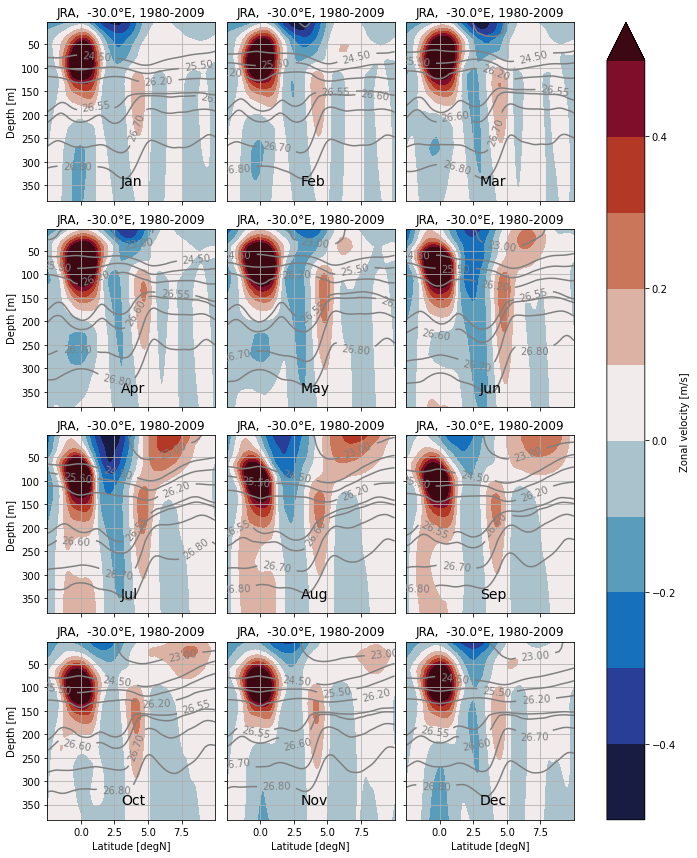

In [21]:
levs = [23, 24.5,25.5, 26.2, 26.55,26.6,26.7,26.8]
lev_u=np.arange(-.5,.6,.1)

lon1 = [-30.5, -23.5,-18]
lon2 = [-29.5, -22.5,-17]
mm_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
idx = 0
with xr.set_options(keep_attrs=True):
    uj = ds_JRA_clim.vozocrtx.sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
    dj = ds_JRA_clim.sigma_0m.sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('JRA,  %3.1f°E, %s-%s' % ((lon1[idx]+lon2[idx])/2,tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (3,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_5}_clim{tlim1}_{tlim2}_30W{fig_format}"),dpi=300)

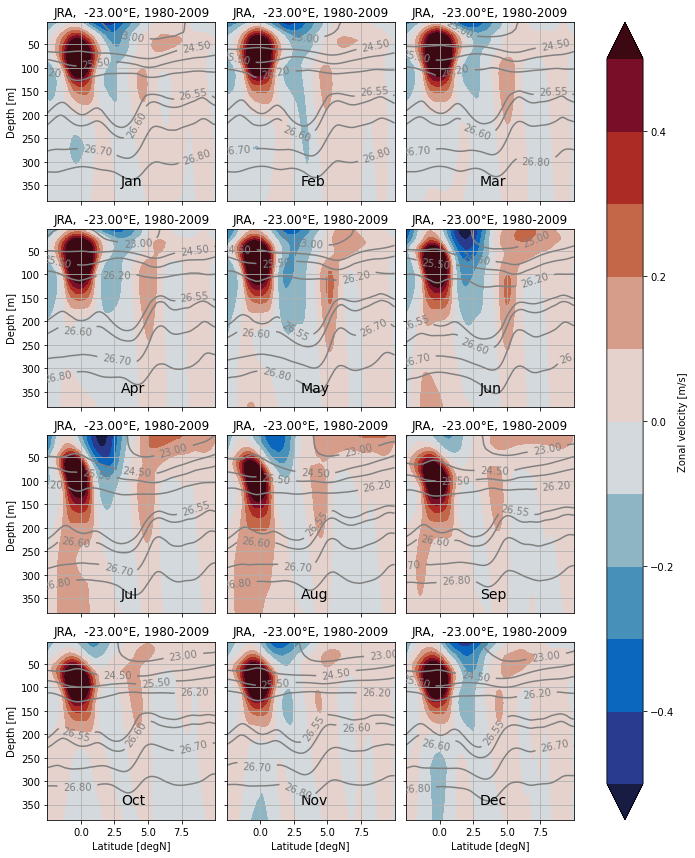

In [22]:
idx = 1
with xr.set_options(keep_attrs=True):
    uj = ds_JRA_clim.vozocrtx.sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
    dj = ds_JRA_clim.sigma_0m.sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('JRA,  %4.2f°E, %s-%s' % ((lon1[idx]+lon2[idx])/2,tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (3,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_5}_clim{tlim1}_{tlim2}_23W{fig_format}"),dpi=300)

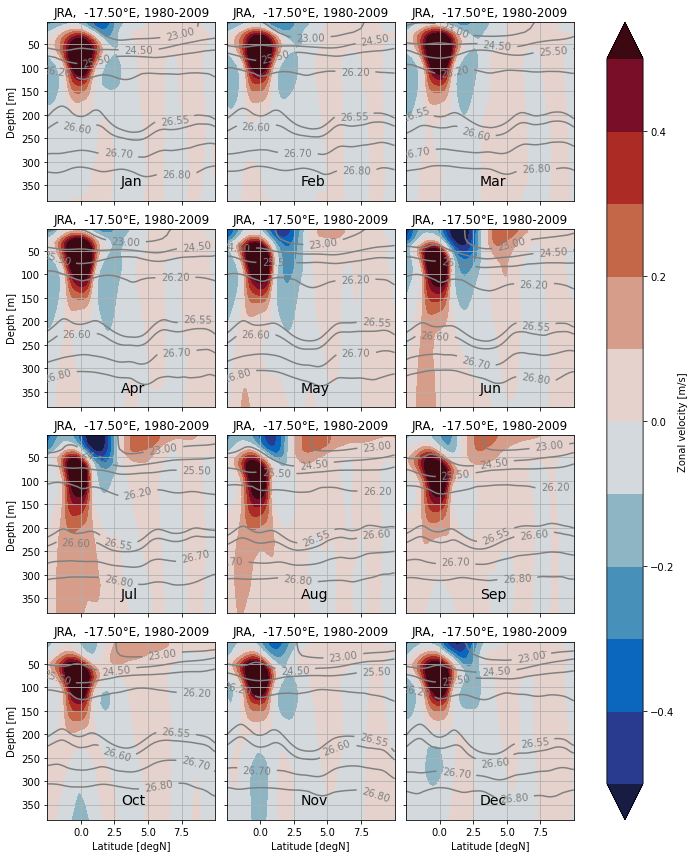

In [28]:
idx = 2
with xr.set_options(keep_attrs=True):
    uj = ds_JRA_clim.vozocrtx.sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
    dj = ds_JRA_clim.sigma_0m.sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('JRA,  %4.2f°E, %s-%s' % ((lon1[idx]+lon2[idx])/2,tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (3,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_5}_clim{tlim1}_{tlim2}_17W{fig_format}"),dpi=300)

### CORE

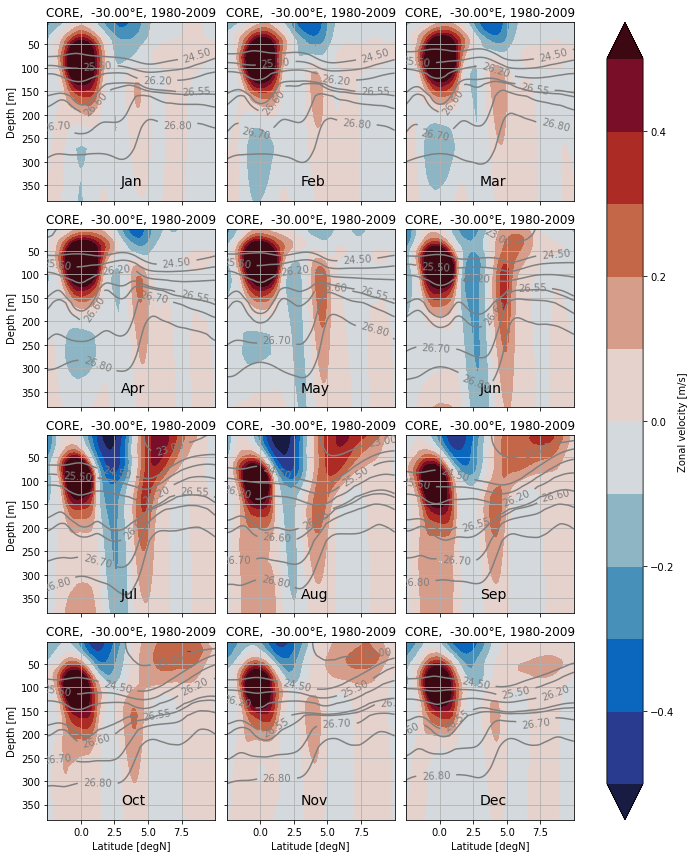

In [24]:
idx = 0
with xr.set_options(keep_attrs=True):
    uj = ds_CORE_clim.vozocrtx.sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
    dj = ds_CORE_clim.sigma_0m.sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('CORE,  %4.2f°E, %s-%s' % ((lon1[idx]+lon2[idx])/2,tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (3,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_6}_clim{tlim1}_{tlim2}_30W{fig_format}"),dpi=300)

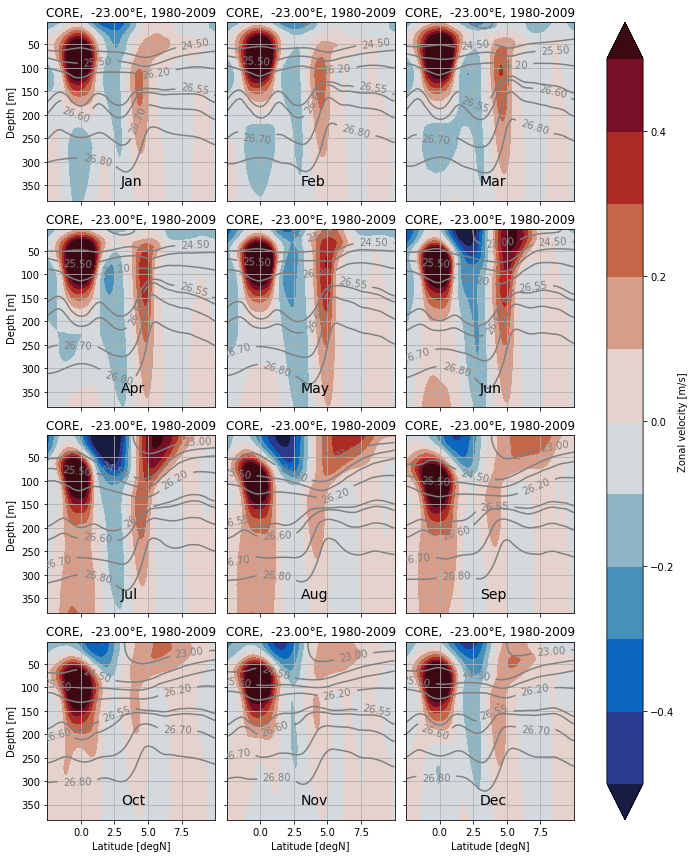

In [25]:
idx = 1
with xr.set_options(keep_attrs=True):
    uj = ds_CORE_clim.vozocrtx.sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
    dj = ds_CORE_clim.sigma_0m.sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('CORE,  %4.2f°E, %s-%s' % ((lon1[idx]+lon2[idx])/2,tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (3,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_6}_clim{tlim1}_{tlim2}_23W{fig_format}"),dpi=300)

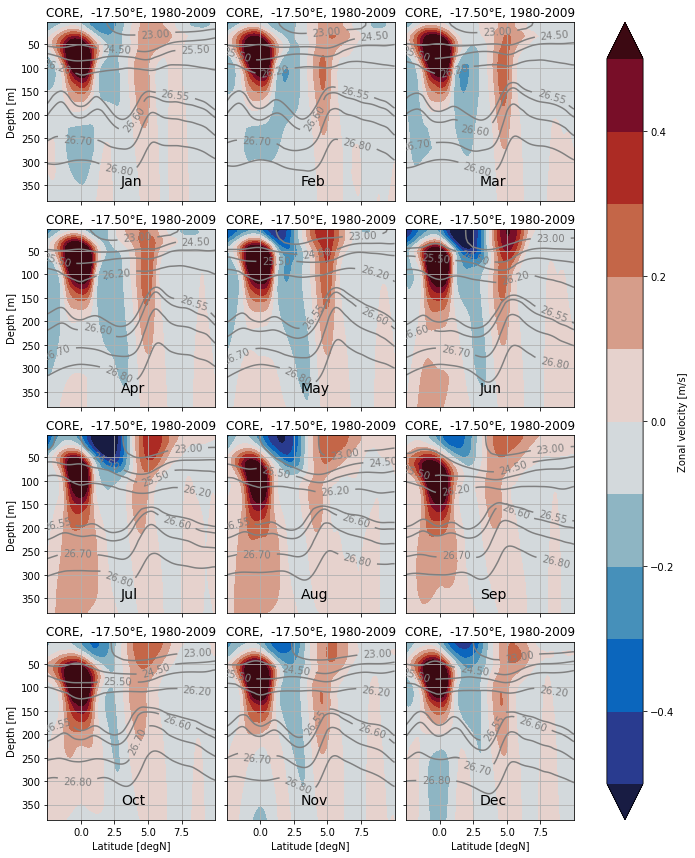

In [27]:
idx = 2
with xr.set_options(keep_attrs=True):
    uj = ds_CORE_clim.vozocrtx.sel(lon_r=slice(lon1[idx],lon2[idx])).mean('lon_r')
    dj = ds_CORE_clim.sigma_0m.sel(lon_c=slice(lon1[idx],lon2[idx])).mean('lon_c')
ph = uj.plot.contourf(y='depthu',x='lat',col='month',col_wrap=3,yincrease=False,
        levels=lev_u,vmin=-1.2,vmax=1.2,cmap=cmocean.cm.balance,robust=True)
for i,ax in enumerate(ph.axes.flat):
    dph=dj.isel(month=i).plot.contour(ax=ax,y='deptht',x='lat',yincrease=False,levels=levs,colors='grey')
    plt.clabel(dph,levels=levs,fmt='%4.2f',fontsize=10)
    ax.set_title('CORE,  %4.2f°E, %s-%s' % ((lon1[idx]+lon2[idx])/2,tlim1,tlim2))
    ax.grid()
    ax.annotate(mm_str[i], (3,350),size=14)
    if i<9:
        ax.set_xlabel('')
    if i in [1,2,4,5,7,8,10,11]:
        ax.set_ylabel('')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_6}_clim{tlim1}_{tlim2}_17W{fig_format}"),dpi=300)